<div align="center">
    <img src="https://www.rohlik.group/profiles/kraken/themes/kraken_theme/images/logo.svg" alt="Rohlic" width="400">
</div>


# Rohlik Sales Forecasting Challenge



Welcome to my Kaggle notebook for the **Rohlik Sales Forecasting Challenge**! Rohlik Group—one of Europe's leading e-grocery innovators with 11 warehouses across multiple countries—is seeking creative solutions to predict inventory sales for the next 14 days. Accurate forecasts help streamline planning, supply chain operations, and inventory management, paving the way for a more sustainable e-grocery future.

---

## Challenge Overview

- **Objective:**  
  Predict the `sales` for each unique inventory-date pair over the next 14 days.

- **Evaluation Metric:**  
  **Weighted Mean Absolute Error (WMAE)**. (Weights are provided in `test_weights.csv`.)

- **Submission Format:**  
  Follow the `solution.csv` template, providing predictions for each test set ID (e.g., `1226_2024-06-03`).

---

## Dataset Breakdown

### Sales Data
- **`sales_train.csv` & `sales_test.csv`:**  
  Historical sales data with features like:
  - `unique_id`
  - `date`
  - `warehouse`
  - `total_orders`
  - `sell_price_main`
  - `availability`
  - Discount metrics  
  *(Note: The `sales` column is absent in the test set.)*

### Inventory Details
- **`inventory.csv`:**  
  Contains additional information about each inventory item, including product IDs and category data.

### Calendar Information
- **`calendar.csv`:**  
  Provides dates with holiday indicators and notes on warehouse closures due to public holidays or weekends.

### Evaluation Weights
- **`test_weights.csv`:**  
  Lists weights for each inventory item used in computing the WMAE.

### Submission Template
- **`solution.csv`:**  
  A template outlining the required format for final predictions.

---

## Notebook Workflow

1. [**Feature Engineering:**]
    Create meaningful features from the raw data.
    * [Calendar](#calendar-preprocessing)
    * [Inventory](#inventory)
    * [Lags](#lag)
    * [Aggregations](#aggregation)
   

2. [**Model Building & Evaluation:**](#training)  
   Develop and assess predictive models using WMAE as the key metric.

3. [**Submission Preparation:**](#submission)  
   Format predictions to match the required submission structure.

---

Let's get started and build a solution that not only meets the challenge requirements but also drives more efficient and sustainable operations at Rohlik!


# Solution

In [55]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm as lgb
from datetime import datetime, date, timedelta
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
import gc
import shap

In [2]:
pd.set_option('display.max_columns', None)
START_DATE =  pd.to_datetime('2020-08-03') #drop two day due to division into fortnights 

In [3]:

def optimize_size(df: pd.DataFrame) -> pd.DataFrame:
    print(f'Size before: {df.memory_usage(deep=True).sum()//1024**2}MB')
    numeric_columns = df.dtypes[df.dtypes.apply(pd.api.types.is_numeric_dtype)].index.to_list()
    max_values = df[numeric_columns].apply(lambda x: x.abs().max())
    for col, val in zip(numeric_columns,max_values):
        if pd.api.types.is_integer_dtype(df[col]):
            if val < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif val < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif val < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        elif pd.api.types.is_float_dtype(df[col]):
            if val < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif val < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    print(f'Size after: {df.memory_usage(deep=True).sum()//1024**2}MB')
    return df
        

In [4]:
calendar = optimize_size(pd.read_csv('calendar.csv'))
inventory = optimize_size(pd.read_csv('inventory.csv'))
train = optimize_size(pd.read_csv('sales_train.csv'))
test = optimize_size(pd.read_csv('sales_test.csv'))
test_weights = pd.read_csv('test_weights.csv')

Size before: 4MB
Size after: 3MB
Size before: 2MB
Size after: 2MB
Size before: 871MB
Size after: 596MB
Size before: 9MB
Size after: 6MB


In [5]:
train.date = pd.to_datetime(train.date)
train = train.loc[train.date >= START_DATE]

train.loc[train.date > max(train.date) - pd.Timedelta(days=14),'dataset'] = 'val'
train.loc[train.date <= max(train.date) - pd.Timedelta(days=14), 'dataset'] = 'train'
test['dataset'] = 'test'
all_data = pd.concat([train, test])
del train, test
gc.collect()
all_data.date = pd.to_datetime(all_data.date)


In [56]:
all_data.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,dataset,price_log,warehouse_city,warehouse_number,country,effective_discount,discounted_price,holiday_name,holiday,shops_closed,day_of_month,day_of_year,days_from_first_sell,fortnight_no,fortnight_day,month,year,weekday,weekend,week,school,sin_day,cos_day,sin_year,cos_year,sin_fortnight,cos_fortnight,sin_week,cos_week,sin_month,cos_month,sin_weekday,cos_weekday,long_weekend_shops_closed,long_weekend_holiday,long_weekend_all,before_next_shop_close,before_next_holiday,before_next_long_weekend,after_last_shop_close,after_last_holiday,after_last_long_weekend,name,product_name,product_number,product_unique_id,categoryS1,categoryS2,categoryS3,categoryS4,sales_14,sales_16,sales_18,sales_21,sales_28,sales_30,sales_35,sales_42,sales_49,sales_60,sales_90,sales_120,sales_180,sales_270,sales_350,sales_600,sales_1000,mean_sales_agg_by_fortnight_no_categoryS1_1,std_sales_agg_by_fortnight_no_categoryS1_1,mean_sales_agg_by_fortnight_no_categoryS2_1,std_sales_agg_by_fortnight_no_categoryS2_1,mean_sales_agg_by_fortnight_no_categoryS3_1,std_sales_agg_by_fortnight_no_categoryS3_1,mean_sales_agg_by_fortnight_no_categoryS4_1,std_sales_agg_by_fortnight_no_categoryS4_1,mean_sales_agg_by_fortnight_no_name_1,std_sales_agg_by_fortnight_no_name_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS1_1,std_sales_agg_by_warehouse_fortnight_no_categoryS1_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS2_1,std_sales_agg_by_warehouse_fortnight_no_categoryS2_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS3_1,std_sales_agg_by_warehouse_fortnight_no_categoryS3_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS4_1,std_sales_agg_by_warehouse_fortnight_no_categoryS4_1,mean_sales_agg_by_warehouse_fortnight_no_name_1,mean_sales_agg_by_warehouse_fortnight_no_name_2,mean_sales_agg_by_warehouse_fortnight_no_name_3,mean_sales_agg_by_warehouse_fortnight_no_name_4,mean_sales_agg_by_warehouse_fortnight_no_name_5,fortnight_5_name_warehouse_weighted_mean,sum_sales_agg_by_warehouse_fortnight_no_name_1,fortnight_5_name_warehouse_weighted_sum,percent_change_in_sales_2,percent_change_in_sales_3,percent_change_in_sales_4,percent_change_in_sales_5,mean_availability_agg_by_warehouse_week_name_2,mean_availability_agg_by_warehouse_week_name_3,mean_availability_agg_by_warehouse_week_name_4,mean_availability_agg_by_warehouse_week_name_5,mean_availability_agg_by_warehouse_week_name_6,week_5_name_warehouse_weighted_mean_availability,weighted_avg_weekday_sales,weight
0,5285,2020-08-03,Prague_1,5012.0,216.375000,20.546875,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,train,3.070312,Prague,1,Czechia,0.000000,20.546875,,0,0,3,216,0,0,0,8,2020,0,0,32,0,0.587891,0.809082,-0.54541,-0.838379,0.0,1.0,-0.663086,-0.748535,-0.866211,-0.5,0.0,1.0,0.0,0.0,0.0,6.0,56.0,54.0,-1.0,-28,-28.0,Onion_52,Onion,52,2601,Fruit and vegetable,Fruit and vegetable_3,Fruit and vegetable_3_63,Fruit and vegetable_3_63_18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926270,0.963867,1.000000,1.000000,1.000000,2.697266,0.0,2.052734
1,2097,2020-08-03,Budapest_1,3546.0,22.734375,626.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,train,6.441406,Budapest,1,Hungary,0.000000,626.000000,,0,0,3,216,0,0,0,8,2020,0,0,32,0,0.587891,0.809082,-0.54541,-0.838379,0.0,1.0,-0.663086,-0.748535,-0.866211,-0.5,0.0,1.0,0.0,0.0,0.0,6.0,17.0,17.0,-1.0,-63,-63.0,Beet_1,Beet,1,1056,Fruit and vegetable,Fruit and vegetable_33,Fruit and vegetable_33_33,Fruit and vegetable_33_33_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995117,0.994141,1.000000,0.972168,0.952148,2.777344,0

In [7]:
all_data['price_log'] = np.log1p(all_data.sell_price_main)

In [8]:
def define_country(city):
    if city in (['Prague','Brno']):
        return 'Czechia'
    elif city in (['Budapest']):
        return 'Hungary'
    else:
        return 'Germany'

In [9]:
all_data.loc[:,['warehouse_city','warehouse_number']] = all_data.warehouse.str.split('_').to_list()
all_data.warehouse_number = all_data.warehouse_number.astype(np.int8)

all_data['country'] = all_data.warehouse_city.apply(define_country)

In [10]:
discount_columns = all_data.filter(regex='type_.*_discount').columns
all_data['effective_discount'] = all_data[discount_columns].clip(lower=0).max(axis = 1)

all_data['discounted_price'] = all_data.sell_price_main * (1-all_data.effective_discount)

## CALENDAR PREPROCESSING

In [11]:
calendar.date = pd.to_datetime(calendar.date)
calendar.holiday_name = calendar.holiday_name.fillna('')
calendar = calendar.loc[calendar.date >= pd.to_datetime('2020-01-01')].sort_values('date')

In [12]:
def long_weekend(df: pd.DataFrame, by_column=None) -> pd.DataFrame:
    df = df.copy()
    df['free_day'] = df['weekend'] | df[by_column].any(axis=1)
    df['block_id'] = (df['free_day'] != df['free_day'].shift()).cumsum()

    # Calculate thn 
    block_sizes = df[df['free_day'] == 1].groupby('block_id')['free_day'].transform('size')

    # Mark days in blocks of size >= 3 as part of a long weekend
    df['long_weekend'] = (block_sizes >= 3).astype(int)
    return df.long_weekend.fillna(0)


In [13]:
def days_to_next_event(df: pd.DataFrame, event: str, rolling_method: str ):
    df = df.copy()
    df['days_to'] = df['date'].where(df[event] == 1, np.nan)
    assert rolling_method in ['bfill','ffill'], 'rolling_method must be one of (bfill, ffill)'
    if rolling_method == 'bfill':
        df['days_to'] = df['days_to'].bfill()
    else:
        df['days_to'] = df['days_to'].ffill()
    df['days_to'] = (pd.to_datetime(df.days_to) - pd.to_datetime(df.date)).dt.days
    return df.days_to.fillna(0)

In [14]:
def calendar_preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:,'day_of_month'] = pd.to_datetime(df.date).dt.day.astype(np.int8)
    df.loc[:, 'day_of_year'] = pd.to_datetime(df.date).dt.day_of_year.astype(np.int16)
    df.loc[:, 'days_from_first_sell'] = (pd.to_datetime(df.date) - START_DATE).dt.days.astype(np.int16) #
    df.loc[:,'fortnight_no'] = (df['days_from_first_sell'] // 14).astype(np.int8)
    df.loc[:, 'fortnight_day'] = (df['days_from_first_sell'] % 14).astype(np.int8)
    df.loc[:,'month'] = pd.to_datetime(df.date).dt.month.astype(np.int8)
    df.loc[:,'year'] = pd.to_datetime(df.date).dt.year.astype(np.int16)
    df.loc[:,'weekday'] = pd.to_datetime(df.date).dt.weekday.astype(np.int8)
    df.loc[:,'weekend'] = (df.weekday >=5).astype(np.int8)
    df.loc[:,'week'] = pd.to_datetime(df.date).dt.isocalendar().week.astype(np.int8)
    df.loc[:,'school']  = df[['winter_school_holidays','school_holidays']].any(axis=1).astype(np.int8)
    df = df.drop(['winter_school_holidays','school_holidays'], axis=1)

    #circle mapping of the date
    df.loc[:,'sin_day'] = np.sin(2*np.pi*df.day_of_month/30)
    df.loc[:,'cos_day'] = np.cos(2*np.pi*df.day_of_month/30)
    df.loc[:,'sin_year'] = np.sin(2*np.pi*df.day_of_year/365)
    df.loc[:,'cos_year'] = np.cos(2*np.pi*df.day_of_year/365)
    df.loc[:,'sin_fortnight'] = np.sin(2*np.pi*df.fortnight_day/14)
    df.loc[:,'cos_fortnight'] = np.cos(2*np.pi*df.fortnight_day/14)
    df.loc[:,'sin_week'] = np.sin(2*np.pi*df.week/52)
    df.loc[:,'cos_week'] = np.cos(2*np.pi*df.week/52)
    df.loc[:,'sin_month'] = np.sin(2*np.pi*df.month/12)
    df.loc[:,'cos_month'] = np.cos(2*np.pi*df.month/12)
    df.loc[:,'sin_weekday'] = np.sin(2*np.pi*df.weekday/7)
    df.loc[:,'cos_weekday'] = np.cos(2*np.pi*df.weekday/7)


    #in hungary and germany shops are closed on every sunday
    df['shops_closed'] = (df['shops_closed'] | df['weekday'] == 6).astype(np.int8)

    df['long_weekend_shops_closed'] = long_weekend(df, ['shops_closed'])
    df['long_weekend_holiday'] = long_weekend(df, ['holiday'])
    # df['long_weekend_school'] = long_weekend(df, ['school'])
    df['long_weekend_all'] = long_weekend(df, ['holiday','shops_closed'])
    
    # how long to next holiday
    df['before_next_shop_close'] = days_to_next_event(df, 'shops_closed','bfill')
    df['before_next_holiday'] = days_to_next_event(df, 'holiday','bfill')
    df['before_next_long_weekend'] = days_to_next_event(df, 'long_weekend_all','bfill')
    df['after_last_shop_close'] = days_to_next_event(df, 'shops_closed','ffill')
    df['after_last_holiday'] = days_to_next_event(df, 'holiday','ffill')
    df['after_last_long_weekend'] = days_to_next_event(df, 'long_weekend_all','ffill')



    return df


In [15]:
calendar = calendar.groupby('warehouse').apply(calendar_preprocess).reset_index(drop=True)

/tmp/ipykernel_1638/4260377723.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calendar = calendar.groupby('warehouse').apply(calendar_preprocess).reset_index(drop=True)


In [16]:
calendar.loc[calendar[['long_weekend_shops_closed', 'long_weekend_holiday','long_weekend_all']].any(axis=1) == 1].tail()

,date,holiday_name,holiday,shops_closed,warehouse,day_of_month,day_of_year,days_from_first_sell,fortnight_no,fortnight_day,month,year,weekday,weekend,week,school,sin_day,cos_day,sin_year,cos_year,sin_fortnight,cos_fortnight,sin_week,cos_week,sin_month,cos_month,sin_weekday,cos_weekday,long_weekend_shops_closed,long_weekend_holiday,long_weekend_all,before_next_shop_close,before_next_holiday,before_next_long_weekend,after_last_shop_close,after_last_holiday,after_last_long_weekend
12723,2024-10-27,,0,1,Prague_3,27,301,1546,110,6,10,2024,6,1,43,0,-0.587785,0.809017,-0.891981,0.452072,4.338837e-01,-0.900969,-8.854560e-01,0.464723,-8.660254e-01,0.5,-0.781831,0.623490,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-29,0.0
12724,2024-10-28,Den vzniku samostatneho ceskoslovenskeho statu,1,0,Prague_3,28,302,1547,110,7,10,2024,0,0,44,0,-0.406737,0.913545,-0.884068,0.467359,1.224647e-16,-1.000000,-8.229839e-01,0.568065,-8.660254e-01,0.5,0.000000,1.000000,0.0,1.0,1.0,6.0,0.0,0.0,-1.0,0,0.0
12781,2024-12-24,Christmas Eve,1,0,Prague_3,24,359,1604,114,8,12,2024,1,0,52,0,-0.951057,0.309017,-0.103102,0.994671,-4.338837e-01,-0.900969,6.432491e-16,1.000000,-2.449294e-16,1.0,0.781831,0.623490,0.0,1.0,1.0,5.0,0.0,0.0,-2.0,0,0.0
12782,2024-12-25,1st Christmas Day,1,0,Prague_3,25,360,1605,114,9,12,2024,2,0,52,0,-0.866025,0.500000,-0.085965,0.996298,-7.818315e-01,-0.623490,6.432491e-16,1.000000,-2.449294e-16,1.0,0.974928,-0.222521,0.0,1.0,1.0,4.0,0.0,0.0,-3.0,0,0.0
12783,2024-12-26,2nd Christmas Day,1,0,Prague_3,26,361,1606,114,10,12,2024,3,0,52,0,-0.743145,0.669131,-0.068802,0.997630,-9.749279e-01,-0.222521,6.432491e-16,1.000000,-2.449294e-16,1.0,0.433884,-0.900969,0.0,1.0,1.0,3.0,0.0,0.0,-4.0,0,0.0


In [17]:
calendar.date = pd.to_datetime(calendar.date)

In [18]:
if not 'holiday' in all_data.columns:
    all_data = pd.merge(all_data, calendar, how='left', on=['date','warehouse'])
    del calendar
    gc.collect()

## INVENTORY

In [19]:
inventory.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [20]:
inventory.loc[:,['product_name']] = inventory.name.apply(lambda x: x.split('_')[0])
inventory.loc[:,['product_number']] = inventory.name.apply(lambda x: int(x.split('_')[1])).astype(int)

In [21]:

inventory.loc[:,['L1_category']] = inventory.L1_category_name_en
inventory.loc[:,['L2_category_number']] = inventory.L2_category_name_en.apply(lambda x: int(x.rsplit('_',1)[1]))
inventory.loc[:,['L3_category_number']] = inventory.L3_category_name_en.apply(lambda x: int(x.rsplit('_',1)[1]))
inventory.loc[:,['L4_category_number']] = inventory.L4_category_name_en.apply(lambda x: int(x.rsplit('_',1)[1]))

inventory.loc[:,['categoryS1']] = inventory.L1_category.astype(str)
inventory.loc[:,['categoryS2']] = inventory['categoryS1'] + '_' +  inventory['L2_category_number'].astype(str)
inventory.loc[:,['categoryS3']] = inventory['categoryS2'] + '_' + inventory['L3_category_number'].astype(str)
inventory.loc[:,['categoryS4']] = inventory['categoryS3'] + '_' + inventory['L4_category_number'].astype(str)


In [22]:
columns = ['unique_id','name','product_name','product_number','product_unique_id', 'categoryS1', 'categoryS2', 'categoryS3', 'categoryS4']
all_data = pd.merge(all_data, inventory[columns], 'left', on='unique_id')
del inventory
gc.collect()

0

In [23]:
all_data = optimize_size(all_data)


Size before: 3752MB
Size after: 3238MB


## LAG

In [24]:
lagged_data = all_data.sort_values('date').groupby(['warehouse','name'])[['sales']].shift([14,16,18,21,28,30,35,42,49,60,90,120,180,270,350,600,1000]).fillna(0)
assert (lagged_data.index == all_data.sort_values('date').index).all()
all_data = pd.concat([all_data.sort_values('date'), lagged_data], axis=1)
del lagged_data
gc.collect()

0

In [25]:
all_data.loc[(all_data.warehouse == 'Brno_1') & (all_data.unique_id == 2278), ['sales', 'sales_14']][:15]

,sales,sales_14
963579,39.656250,0.00000
963346,26.093750,0.00000
963515,30.890625,0.00000
963760,40.312500,0.00000
963150,46.062500,0.00000
963836,35.125000,0.00000
962764,52.125000,0.00000
962791,32.031250,0.00000
963282,32.062500,0.00000
963339,31.656250,0.00000


## AGGREGATION

In [26]:
def aggregate_sales_by_category(df: pd.DataFrame, time_period: str, category_list: list[str], add_grouping: list[str] = [], lags: list[int] = [1], agg_functions: list[str]  = ["mean","std"], aggregation_col: str ='sales'):
    #columns rename
    keys = sorted({f"{aggregation_col}_{agg_fun}" for agg_fun in agg_functions})
    for category in category_list:
        group_by_cols = add_grouping + [time_period, category]
        agg_data = pd.DataFrame(df.sort_values('date').groupby( group_by_cols).agg({aggregation_col: agg_functions})).reset_index()
        agg_data.columns = ['_'.join(col).strip('_ ') for col in agg_data.columns.values]
        final_name = f"{aggregation_col}_agg_by_{'_'.join(group_by_cols)}"
        for lag in lags:
            data = agg_data.copy()
            data =  data.rename(columns = dict(zip(keys, sorted({f"{agg_fun}_{final_name}_{lag}" for agg_fun in agg_functions})))) # rename from sales_sum to meaningful name
            data[time_period] += lag
            df = df.merge(data, 'left', on=group_by_cols)
            del data
            gc.collect()
        del agg_data
        gc.collect()
    return df

In [27]:
all_data = aggregate_sales_by_category(all_data, 'fortnight_no', ['categoryS1','categoryS2','categoryS3','categoryS4','name'])
all_data = aggregate_sales_by_category(all_data, 'fortnight_no', ['categoryS1', 'categoryS2','categoryS3','categoryS4'], add_grouping=['warehouse'])
all_data = aggregate_sales_by_category(all_data, 'fortnight_no', ['name'], add_grouping=['warehouse'], lags=[1,2,3,4,5], agg_functions=["mean"])
# all_data = aggregate_sales_by_category(all_data, 'week', ['name'], add_grouping=['warehouse'], lags=[2,3,4,5,6], agg_functions=["mean"])

In [28]:
def compute_weighted_mean(df, column_name, lags, weights):
    if len(lags) != len(weights):
        raise ValueError("The number of lags and weights must be the same.")

    weighted_sum = sum(
        weight * df[f"{column_name}_{lag}"]
        for lag, weight in zip(lags, weights)
    )
    return weighted_sum


In [29]:
all_data['fortnight_5_name_warehouse_weighted_mean'] = compute_weighted_mean(all_data, 'mean_sales_agg_by_warehouse_fortnight_no_name', [1,2,3,4,5], [1, 0.8, 0.6, 0.3, 0.1])

In [30]:
# PERCENTAGE CHANGE IN SUM OF SALES SIMULATE SHIFTS IN DEMAND AT GIVEN TIMEPE PERIOD
all_data = aggregate_sales_by_category(all_data, 'fortnight_no', ['name'], add_grouping=['warehouse'], lags=[1,2,3,4,5], agg_functions=["sum"])
all_data['fortnight_5_name_warehouse_weighted_sum'] = compute_weighted_mean(all_data, 'sum_sales_agg_by_warehouse_fortnight_no_name', [1,2,3,4,5], [1, 0.8, 0.6, 0.3, 0.1])

In [31]:
for lag in [2,3,4,5]:
    all_data[f'percent_change_in_sales_{lag}'] = (all_data['sum_sales_agg_by_warehouse_fortnight_no_name_1'] - all_data[f'sum_sales_agg_by_warehouse_fortnight_no_name_{lag}'])/ all_data[f'sum_sales_agg_by_warehouse_fortnight_no_name_{lag}'] * 100
    all_data.drop(f'sum_sales_agg_by_warehouse_fortnight_no_name_{lag}', axis=1, inplace=True)

In [32]:
#AVIALABILITY

all_data = aggregate_sales_by_category(all_data, 'week', ['name'], add_grouping=['warehouse'], lags=[2,3,4,5,6], agg_functions=["mean"], aggregation_col='availability')
all_data['week_5_name_warehouse_weighted_mean_availability'] = compute_weighted_mean(all_data, 'mean_availability_agg_by_warehouse_week_name', [2,3,4,5,6], [1, 0.8, 0.6, 0.3, 0.1])


In [33]:
# aggreagtion from last 5 fortnights for the same weekday
all_data['weighted_avg_weekday_sales'] = compute_weighted_mean(all_data, 'sales', [14,21,28,35,42,49], [1, 0.8, 0.6, 0.4, 0.25, 0.1])


## TRAINING

In [34]:
all_data = pd.merge(all_data, test_weights, 'left', on='unique_id')

In [35]:
def is_string_column(col):
    return all(isinstance(x, str) for x in col)

string_columns = [col for col in all_data.columns if is_string_column(all_data[col])]


In [36]:
string_columns

['warehouse',
 'dataset',
 'warehouse_city',
 'country',
 'holiday_name',
 'name',
 'product_name',
 'categoryS1',
 'categoryS2',
 'categoryS3',
 'categoryS4']

In [37]:
all_data

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,dataset,price_log,warehouse_city,warehouse_number,country,effective_discount,discounted_price,holiday_name,holiday,shops_closed,day_of_month,day_of_year,days_from_first_sell,fortnight_no,fortnight_day,month,year,weekday,weekend,week,school,sin_day,cos_day,sin_year,cos_year,sin_fortnight,cos_fortnight,sin_week,cos_week,sin_month,cos_month,sin_weekday,cos_weekday,long_weekend_shops_closed,long_weekend_holiday,long_weekend_all,before_next_shop_close,before_next_holiday,before_next_long_weekend,after_last_shop_close,after_last_holiday,after_last_long_weekend,name,product_name,product_number,product_unique_id,categoryS1,categoryS2,categoryS3,categoryS4,sales_14,sales_16,sales_18,sales_21,sales_28,sales_30,sales_35,sales_42,sales_49,sales_60,sales_90,sales_120,sales_180,sales_270,sales_350,sales_600,sales_1000,mean_sales_agg_by_fortnight_no_categoryS1_1,std_sales_agg_by_fortnight_no_categoryS1_1,mean_sales_agg_by_fortnight_no_categoryS2_1,std_sales_agg_by_fortnight_no_categoryS2_1,mean_sales_agg_by_fortnight_no_categoryS3_1,std_sales_agg_by_fortnight_no_categoryS3_1,mean_sales_agg_by_fortnight_no_categoryS4_1,std_sales_agg_by_fortnight_no_categoryS4_1,mean_sales_agg_by_fortnight_no_name_1,std_sales_agg_by_fortnight_no_name_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS1_1,std_sales_agg_by_warehouse_fortnight_no_categoryS1_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS2_1,std_sales_agg_by_warehouse_fortnight_no_categoryS2_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS3_1,std_sales_agg_by_warehouse_fortnight_no_categoryS3_1,mean_sales_agg_by_warehouse_fortnight_no_categoryS4_1,std_sales_agg_by_warehouse_fortnight_no_categoryS4_1,mean_sales_agg_by_warehouse_fortnight_no_name_1,mean_sales_agg_by_warehouse_fortnight_no_name_2,mean_sales_agg_by_warehouse_fortnight_no_name_3,mean_sales_agg_by_warehouse_fortnight_no_name_4,mean_sales_agg_by_warehouse_fortnight_no_name_5,fortnight_5_name_warehouse_weighted_mean,sum_sales_agg_by_warehouse_fortnight_no_name_1,fortnight_5_name_warehouse_weighted_sum,percent_change_in_sales_2,percent_change_in_sales_3,percent_change_in_sales_4,percent_change_in_sales_5,mean_availability_agg_by_warehouse_week_name_2,mean_availability_agg_by_warehouse_week_name_3,mean_availability_agg_by_warehouse_week_name_4,mean_availability_agg_by_warehouse_week_name_5,mean_availability_agg_by_warehouse_week_name_6,week_5_name_warehouse_weighted_mean_availability,weighted_avg_weekday_sales,weight
0,5285,2020-08-03,Prague_1,5012.0,216.375000,20.546875,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,train,3.070312,Prague,1,Czechia,0.000000,20.546875,,0,0,3,216,0,0,0,8,2020,0,0,32,0,0.587891,0.809082,-0.54541,-0.838379,0.000000,1.000000,-0.663086,-0.748535,-0.866211,-0.5,0.000000,1.000000,0.0,0.0,0.0,6.0,56.0,54.0,-1.0,-28,-28.0,Onion_52,Onion,52,2601,Fruit and vegetable,Fruit and vegetable_3,Fruit and vegetable_3_63,Fruit and vegetable_3_63_18,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926200,0.963809,1.000000,1.000000,1.000000,2.697247,0.00000,2.052168
1,2097,2020-08-03,Budapest_1,3546.0,22.734375,626.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,train,6.441406,Budapest,1,Hungary,0.000000,626.000000,,0,0,3,216,0,0,0,8,2020,0,0,32,0,0.587891,0.809082,-0.54541,-0.838379,0.000000,1.000000,-0.663086,-0.748535,-0.866211,-0.5,0.000000,1.000000,0.0,0.0,0.0,6.0,17.0,17.0,-1.0,-63,-63.0,Beet_1,Beet,1,1056,Fruit and vegetable,Fruit and vegetable_33,Fruit and vegetable_33_33,Fruit and vegetable_33_33_1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.0

In [38]:
categorical_features = ['warehouse','warehouse_city', 'holiday_name', 'categoryS1', 'categoryS2', 'categoryS3', 'categoryS4', 'product_name', 'name', 'country']
features = ['unique_id', 'date', 'warehouse', 'total_orders', 'sales',
       'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'dataset', 'warehouse_city',
       'warehouse_number', 'country', 'holiday_name', 'holiday',
       'shops_closed', 'day_of_month', 'day_of_year', 'days_from_first_sell',
       'fortnight_no', 'fortnight_day', 
         'year', 'weekday', 'weekend',
       'week', 'school', 'long_weekend_shops_closed', 'long_weekend_holiday',
       'long_weekend_all', 
       'before_next_shop_close',
       'before_next_holiday', 'before_next_long_weekend',
       'after_last_shop_close', 'after_last_holiday',
       'after_last_long_weekend', 'name', 'product_name', 'product_number',
       'product_unique_id', 'categoryS1', 'categoryS2',
       'categoryS3', 'categoryS4', 
       'sales_14', 'sales_16', 'sales_18','sales_21', 'sales_30', 'sales_60', # better performance close to 20
       'sales_90', 'sales_120','sales_180', 'sales_270', 'sales_350', 'sales_600', 'sales_1000',
       'mean_sales_agg_by_fortnight_no_categoryS1_1', 'mean_sales_agg_by_fortnight_no_categoryS2_1',
       'mean_sales_agg_by_fortnight_no_categoryS3_1', 'mean_sales_agg_by_fortnight_no_categoryS4_1',
       'mean_sales_agg_by_fortnight_no_name_1', 
       'mean_sales_agg_by_warehouse_fortnight_no_categoryS1_1','mean_sales_agg_by_warehouse_fortnight_no_categoryS2_1','mean_sales_agg_by_warehouse_fortnight_no_categoryS3_1','mean_sales_agg_by_warehouse_fortnight_no_categoryS4_1',
       'fortnight_5_name_warehouse_weighted_mean',
       'sin_week', 'sin_day', 'sin_year', 'sin_weekday', 'sin_fortnight', 'sin_month',
       'cos_year', 'cos_weekday', 'cos_week', 'cos_fortnight', 'cos_day', 'cos_month',
       'week_5_name_warehouse_weighted_mean_availability',
                  ]
drop_features = ['weight','dataset','date','sales',
'mean_sales_agg_by_warehouse_fortnight_no_name_1','mean_sales_agg_by_warehouse_fortnight_no_name_2','mean_sales_agg_by_warehouse_fortnight_no_name_3','mean_sales_agg_by_warehouse_fortnight_no_name_4','mean_sales_agg_by_warehouse_fortnight_no_name_5',
'before_next_shop_close','month'
]

features = list(set(features) - set(drop_features))
categorical_features = list(set(categorical_features) - set(drop_features))
TARGET = ['sales']
WEIGHTS = ['weight']

In [39]:
additional = list(set(all_data.columns) - set(features) - set(TARGET) - set(WEIGHTS) - set(drop_features))
additional

['mean_availability_agg_by_warehouse_week_name_5',
 'std_sales_agg_by_warehouse_fortnight_no_categoryS2_1',
 'std_sales_agg_by_warehouse_fortnight_no_categoryS3_1',
 'sales_35',
 'std_sales_agg_by_warehouse_fortnight_no_categoryS4_1',
 'weighted_avg_weekday_sales',
 'sum_sales_agg_by_warehouse_fortnight_no_name_1',
 'discounted_price',
 'percent_change_in_sales_2',
 'fortnight_5_name_warehouse_weighted_sum',
 'std_sales_agg_by_fortnight_no_name_1',
 'percent_change_in_sales_4',
 'sales_28',
 'std_sales_agg_by_fortnight_no_categoryS1_1',
 'percent_change_in_sales_5',
 'sales_49',
 'std_sales_agg_by_fortnight_no_categoryS3_1',
 'mean_availability_agg_by_warehouse_week_name_2',
 'std_sales_agg_by_fortnight_no_categoryS2_1',
 'std_sales_agg_by_fortnight_no_categoryS4_1',
 'mean_availability_agg_by_warehouse_week_name_3',
 'mean_availability_agg_by_warehouse_week_name_6',
 'std_sales_agg_by_warehouse_fortnight_no_categoryS1_1',
 'price_log',
 'sales_42',
 'mean_availability_agg_by_warehouse

In [40]:
numeric = list(set(features) - set(categorical_features))
correlation_values = all_data[numeric].corr()

<Axes: >

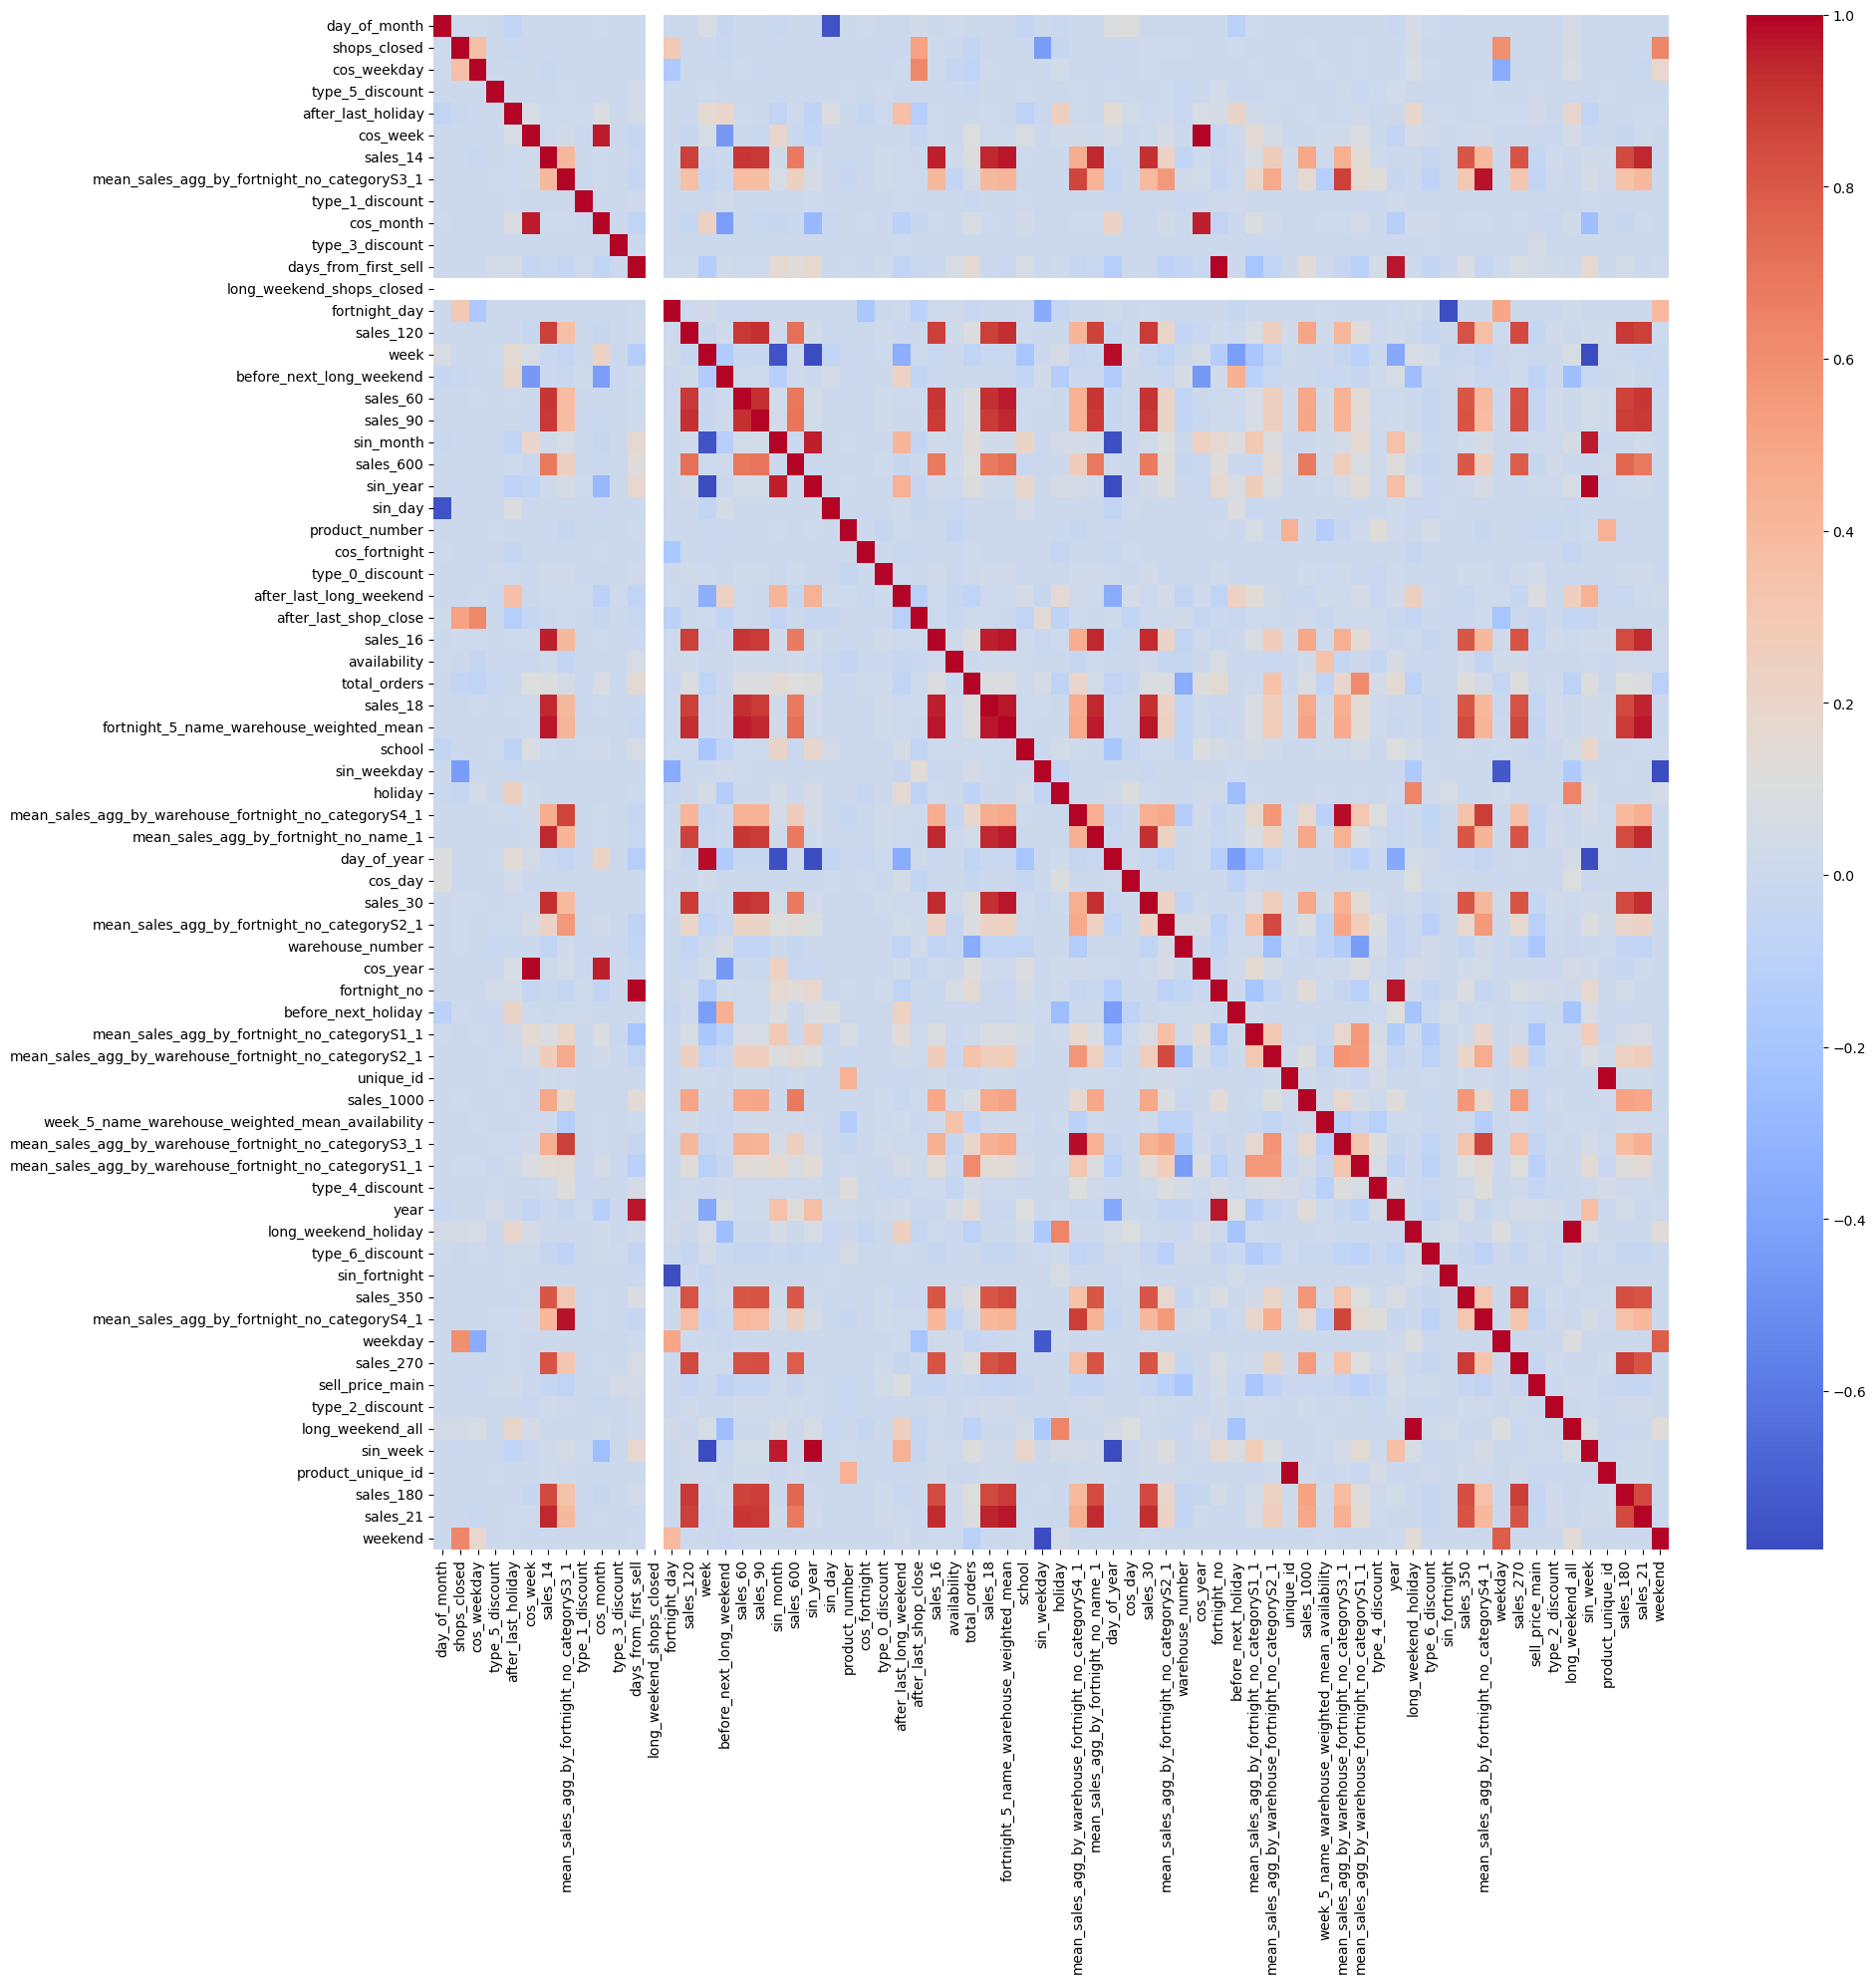

In [41]:
plt.figure(figsize=(20,20))
sns.heatmap(correlation_values, cmap='coolwarm')

In [42]:
all_data[categorical_features] = all_data[categorical_features].astype('category')

In [43]:
params={ 
    'learning_rate': 0.021796506746095975,
    'num_leaves': 93,
    'max_depth': 10,
    'min_child_samples': 25,
    'subsample': 0.7057135664023435,
    'colsample_bytree': 0.8528497905459008,
    'reg_alpha': 0.036786449788597686,
    'reg_lambda': 0.3151110021900479,
    'num_boost_round': 9800,
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'verbose':0
}

In [44]:
train = all_data.loc[all_data.dataset == 'train', :]
val = all_data.loc[all_data.dataset == 'val', :] 
test = all_data.loc[all_data.dataset == 'test', :]


In [45]:
callbacks = [lgb.log_evaluation(period=700)]
model_lgb = lgb.LGBMRegressor(**params)
model_lgb.fit(train[features], train[TARGET], sample_weight=train[WEIGHTS[0]],
        eval_set=[(val[features], val[TARGET])],
        eval_sample_weight=[val[WEIGHTS[0]]],
        categorical_feature=categorical_features,
        callbacks=callbacks)


/home/marcel/miniforge3/envs/python3.11/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=9800, num_boost_round=9800 will be ignored. Current value: num_iterations=9800
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] num_iterations is set=9800, num_boost_round=9800 will be ignored. Current value: num_iterations=9800
[700]	valid_0's l1: 19.1789
[1400]	valid_0's l1: 18.632
[2100]	valid_0's l1: 18.3581
[2800]	valid_0's l1: 18.2228
[3500]	valid_0's l1: 18.1584
[4200]	valid_0's l1: 18.0766
[4900]	valid_0's l1: 18.0335
[5600]	valid_0's l1: 17.9904
[6300]	valid_0's l1: 17.9602
[7000]	valid_0's l1: 17.9327
[7700]	valid_0's l1: 17.9375
[8400]	valid_0's l1: 17.928
[9100]	valid_0's l1: 17.8954
[9800]	valid_0's l1: 17.8898


/home/marcel/miniforge3/envs/python3.11/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(colsample_bytree=0.8528497905459008,
              learning_rate=0.021796506746095973, max_depth=10, metric='mae',
              min_child_samples=25, num_boost_round=9800, num_leaves=93,
              objective='regression', reg_alpha=0.036786449788597686,
              reg_lambda=0.3151110021900479, subsample=0.7057135664023435,
              verbose=0)

In [46]:
all_data = optimize_size(all_data)

Size before: 1545MB
Size after: 1213MB


In [47]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer(val[features])

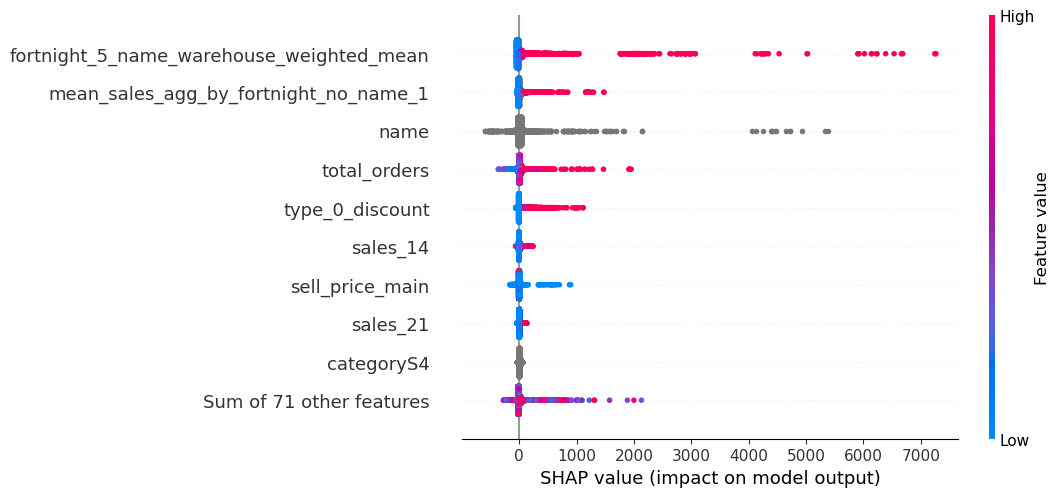

In [48]:
shap.plots.beeswarm(shap_values)

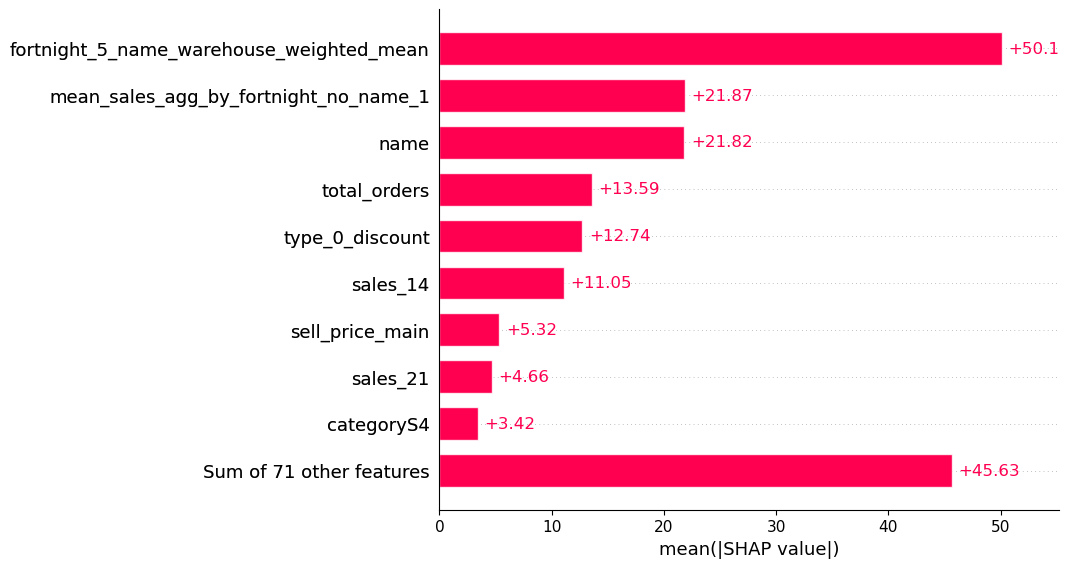

In [50]:
shap.plots.bar(shap_values,max_display=10)

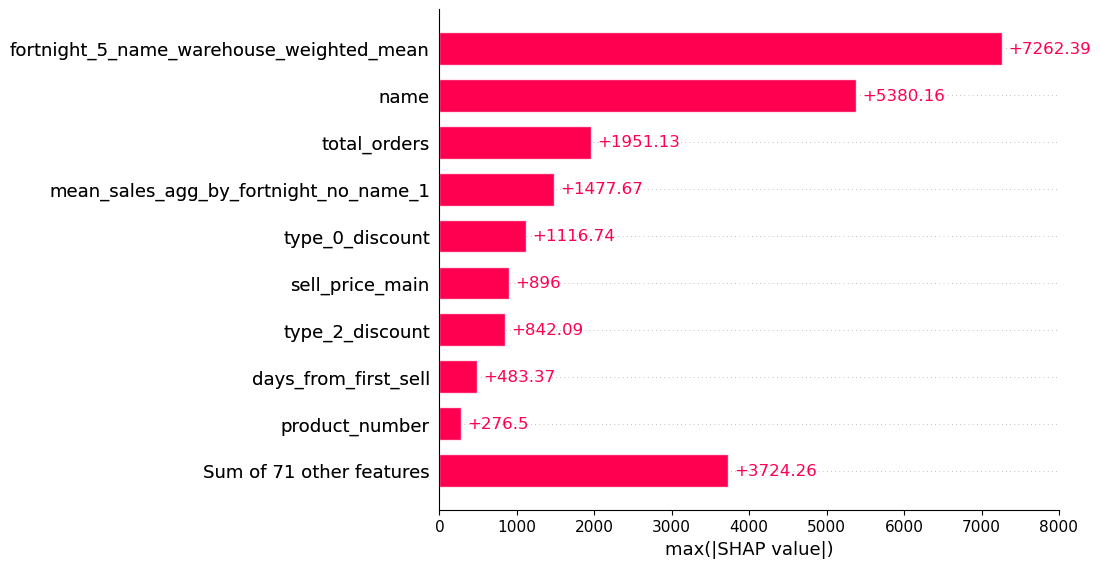

In [51]:
shap.plots.bar(shap_values.abs.max(0), max_display=10)

## Submission

In [52]:
def prepare_pred(test_data, predicitons):
    test_data = pd.DataFrame(test_data)
    test_data.loc[:,'sales_hat'] = predicitons
    year =  test_data.year.astype(int).astype(str) 
    month = test_data.month.astype(int).astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
    day = test_data.day_of_month.astype(int).astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
    test_data.loc[:,'id'] = test_data.unique_id.astype(str) + '_' + year + '-' + month + '-' + day
    test_data.set_index('id', inplace=True)
    return test_data[['sales_hat']]


In [53]:
pred_sub = model_lgb.predict(test[features])
submition = prepare_pred(test, pred_sub)
submition.to_csv('submition_2025_02_13_baseparameters_baseline_sincosdate_availability.csv')

In [54]:
#history of results:
#19.99951 based on features 19.65 with params from kaggle
#28.6 all basic featere extraction without any time series based on data > 2024-01-01
#31.564273432873122 just random forest regressor with 10 estimators
#82.92810071439021 linear regression only train sales 